# **Convolutional Neural Networks (Basics)**
CNNs form the basis of modern Deep Learning methods for image processing tasks. Instead of using fully-connected layers as in the case MLPs, CNNs use convolutions as the main building blocks. This allows to drastically reduce the number of parameters and provide translation-invariance properties to the network.

## Simple example with Convolutions in PyTorch

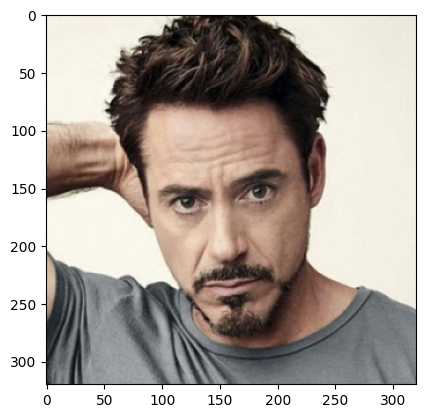

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([9, 3, 5, 5])


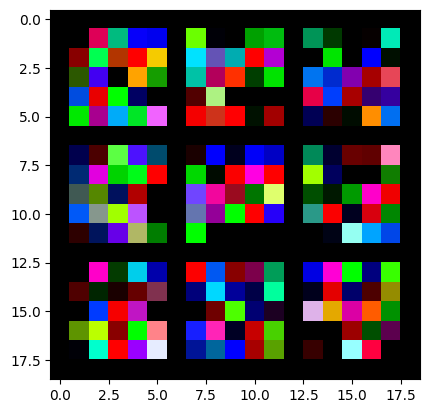

In [6]:
import torch.nn as nn
import torch
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import os

# Load an image
try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + 'Results/'

image = Image.open(data_path + 'face_image.jpg')
plt.imshow(image)
plt.show()

kernel_size = 5 # Dimension of the convolutional kernel
in_channels = 3 # For RGB images
out_channels = 9 # Number of convolutions in parallel

# Initialize a 2D Convolution module in PyTorch
conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=2, bias=False)
print(conv1.weight.shape)

# Convert image to Pytorch Tensor
to_tensor_tf = tf.ToTensor()
image_pt = to_tensor_tf(image)
image_pt = image_pt.unsqueeze(0) # Add a first dimension for proccessing

# Visualize filters 
convolution_grid = make_grid(conv1.weight,nrow=3,padding=1)
plt.imshow(convolution_grid.permute(1,2,0).detach().numpy()*10)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size before convolution: torch.Size([1, 3, 320, 320])
Size after convolution: torch.Size([1, 9, 320, 320])


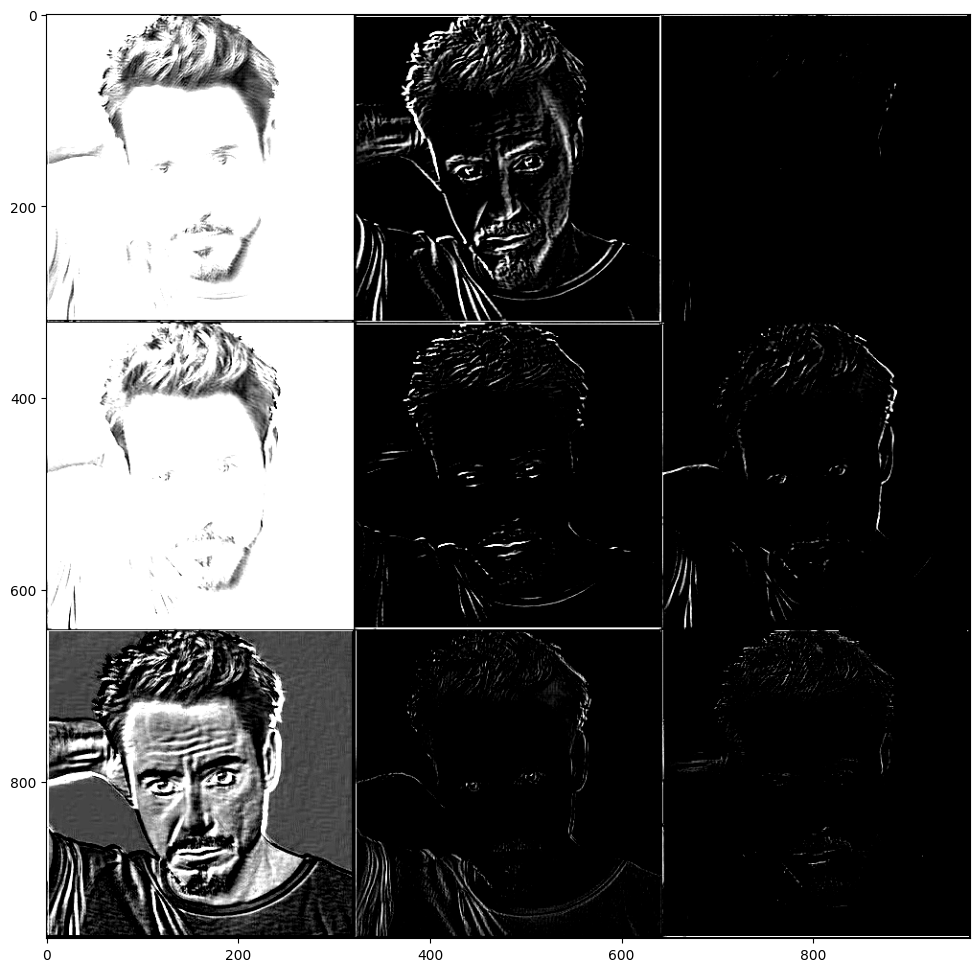

In [7]:
# Apply filters to the image
convolved_image = conv1(image_pt)
print("Size before convolution: " + str(image_pt.shape))
print("Size after convolution: " + str(convolved_image.shape))

# Visualize feature channels after convolution
feature_channels_grid = make_grid(convolved_image.permute(1,0,2,3),nrow=3,padding=1)
plt.figure(figsize=(12,12))
plt.imshow(feature_channels_grid.permute(1,2,0).detach().numpy()*10)
plt.show()

## Simple convolutional parameters optimization (Let's  train an edge detector!)

Text(0.5, 1.0, 'Masked Image')

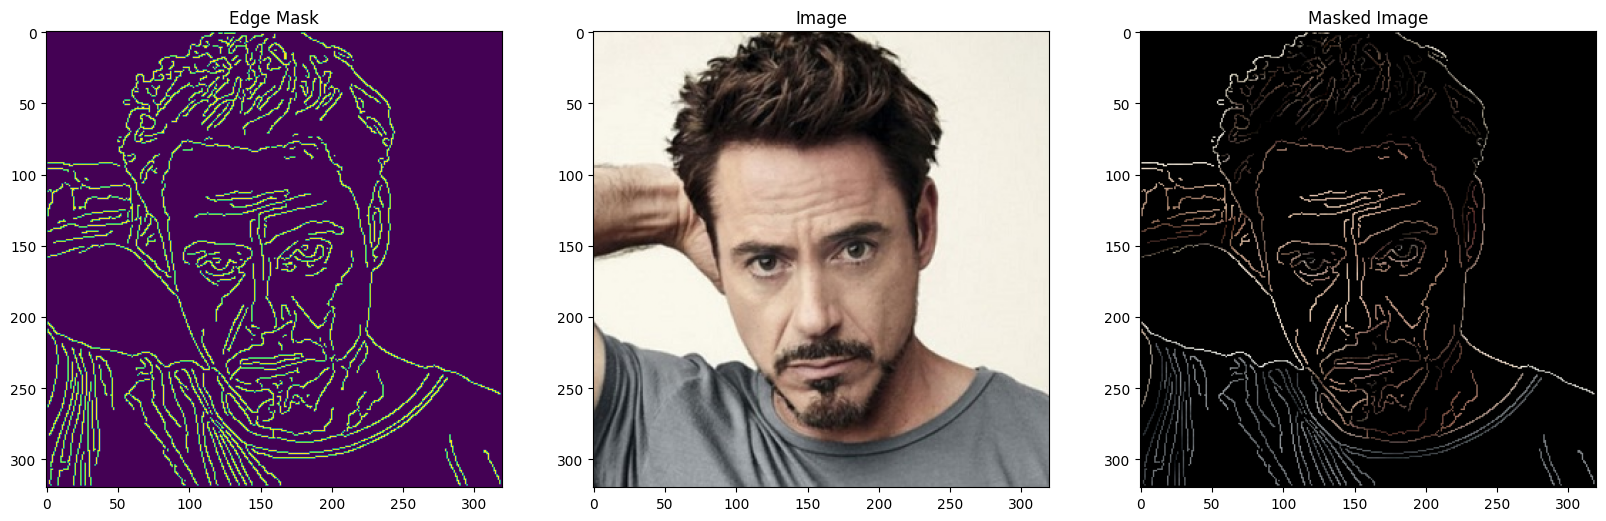

In [8]:
# Open a biinary image defining where the edges of the image are located
eyes_mask = Image.open(data_path + 'face_image_mask.png')
to_tensor_tf = tf.ToTensor()
eyes_mask_pt = (to_tensor_tf(eyes_mask))[0,:,:]

# Visualize the original image and edges
plt.figure(figsize=(20,60))
plt.subplot(1,3,1)
plt.imshow(eyes_mask_pt.numpy())
plt.title('Edge Mask')
plt.subplot(1,3,2)
plt.imshow(image_pt.squeeze().permute(1,2,0).numpy())
plt.title('Image')
plt.subplot(1,3,3)
plt.imshow((eyes_mask_pt*image_pt).squeeze().permute(1,2,0).numpy())
plt.title('Masked Image')


In [10]:
# Define a neural network with two convolutional layers that will output the probability
# of edge in each pixel

#First convolutional layer
in_channels = 3
out_channels = 25
kernel_size = 7
conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=3)

#Second convolutional layer
in_channels = 25 # will receive the input of the last layer
out_channels = 1 # will output the edge score
kernel_size = 5
conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=2)

# Store the network and images in CUDA to use GPU processing
conv1 = conv1# .cuda()
conv2 = conv2# .cuda()
image_pt_c = image_pt# .cuda()
eyes_mask_pt_pad = eyes_mask_pt.unsqueeze(0)# .cuda()

# Initialize an SGD optimizer with the paramters of conv1 and conv2
optimizer = torch.optim.SGD(list(conv1.parameters()) + list(conv2.parameters()),  
                            lr=0.01, momentum=0.9, weight_decay=0.005)

# Apply gradient-descent to train the edge detector
nIt = 5000
for it in range(0,nIt):
  # Apply first convolution and a ReLU activation function
  conv_image = torch.relu(conv1(image_pt_c))
  # Apply second convolution and apply a sigmoid function to get the edge probability
  prob = torch.sigmoid(conv2(conv_image))

# Compute cross-entropy loss for each pixel using the mask image as ground-truth 
  loss_pixels  = 5*(eyes_mask_pt_pad * torch.log(prob)) + \
                ((1 - eyes_mask_pt_pad) * torch.log(1 - prob))
  
  # Average the loss over all the pixels in the image
  loss_val = -loss_pixels.mean()

  if(it%500==0):
    print('Iteration: ' + str(it) + " - Loss: " + str(loss_val.item()))

  # Update paramters  
  optimizer.zero_grad()
  loss_val.backward()

  optimizer.step()



Iteration: 0 - Loss: 0.9156237840652466


KeyboardInterrupt: 

### Visualize the trained edge detector

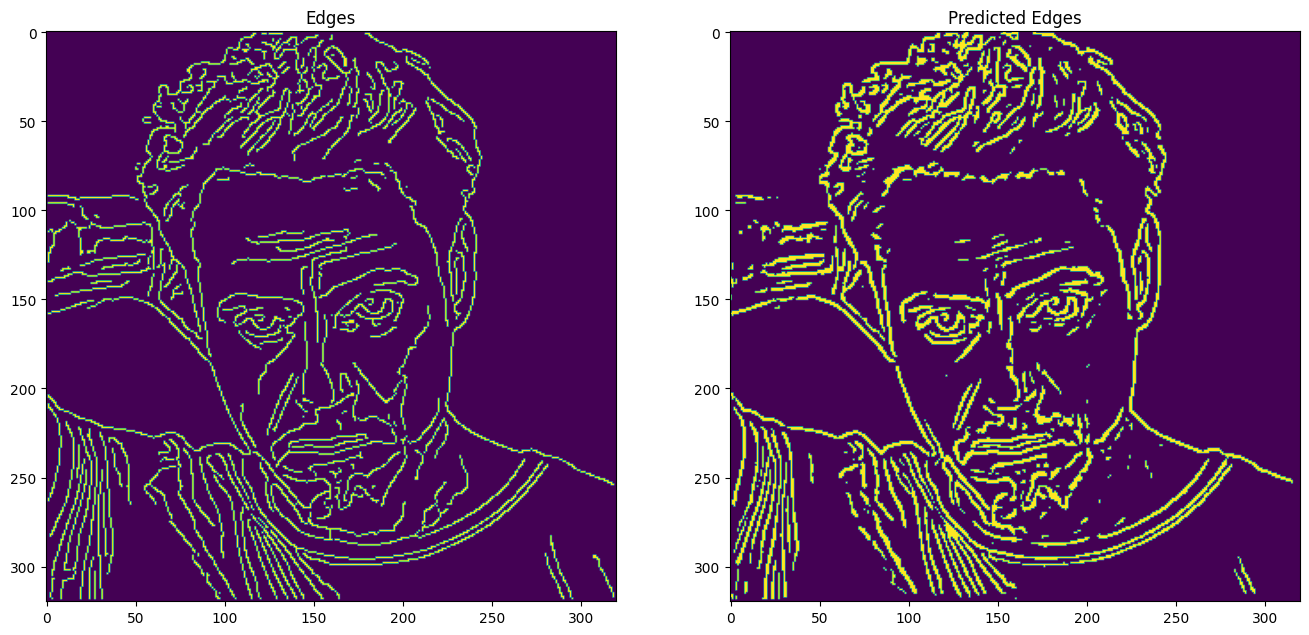

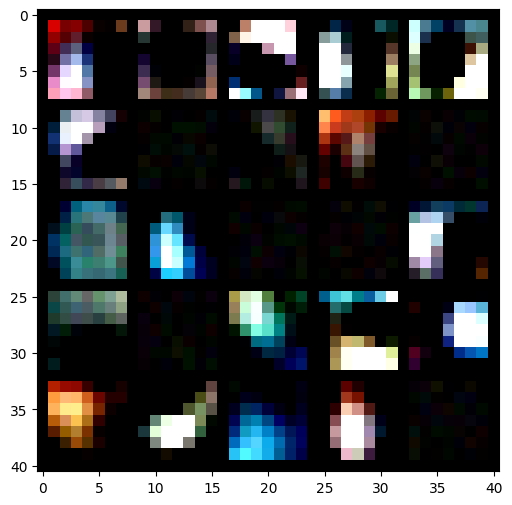

In [5]:
# Compute edge probabilities using the trained convolutions
conv_image = torch.relu(conv1(image_pt_c))
prob = torch.sigmoid(conv2(conv_image))

# Visualize original edges and predicted edges
plt.figure(figsize=(25,8))

plt.subplot(1,3,1)
plt.imshow(eyes_mask_pt.numpy())
plt.title('Edges')

plt.subplot(1,3,2)
plt.imshow(prob.detach().squeeze().cpu().numpy()>0.5)
plt.title('Predicted Edges')
plt.show()

# Visualize the learned filters of the first convolution
plt.figure(figsize=(6,6))
convolution_grid = make_grid(conv1.weight.cpu(),nrow=5,padding=1)
plt.imshow(convolution_grid.permute(1,2,0).detach().numpy()*10)
plt.show()

# **Data Loading in Pytorch**
PyTorch offers many tools to load and pre-process data for Deep Learning. One of the most usefull classes are implemented in the library torch.utils.data.
Let's see some examples

## The Dataset / DataLoader and transform classes




In [6]:
'''
class CustomDataset(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self):
        
        pass
    # What to do to load a single item in the dataset    
    def __getitem__(self, index):
        pass
    # Function returnning the number of samples in the dataset    
    def __len__(self):
        return 0 


# You can then use the prebuilt data loader. 
custom_dataset = CustomDataset()

# DataLoader is usefull to iterate over the dataset (samples batches)
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=64, 
                                           shuffle=True)
                                           
# Mini-batch images and labels.
images, labels = next(iter(dataloader)) #data_iter.next()

# Actual usage of the data loader is as below.
for images, labels in train_loader:
    # Training code should be written here.
    pass
    
# Many image/data transformations are implemented in pytroch : 
transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(), 
        transforms.Normalize(mean = (.5,.5,.5), std = (.5,.5,.5))
        ])
        

    
'''

'\nclass CustomDataset(torch.utils.data.Dataset):\n    # Initialization method for the dataset\n    def __init__(self):\n        \n        pass\n    # What to do to load a single item in the dataset    \n    def __getitem__(self, index):\n        pass\n    # Function returnning the number of samples in the dataset    \n    def __len__(self):\n        return 0 \n\n\n# You can then use the prebuilt data loader. \ncustom_dataset = CustomDataset()\n\n# DataLoader is usefull to iterate over the dataset (samples batches)\ntrain_loader = torch.utils.data.DataLoader(dataset=custom_dataset,\n                                           batch_size=64, \n                                           shuffle=True)\n                                           \n# Mini-batch images and labels.\nimages, labels = next(iter(dataloader)) #data_iter.next()\n\n# Actual usage of the data loader is as below.\nfor images, labels in train_loader:\n    # Training code should be written here.\n    pass\n    \n# Many 

## Create a Custom Dataset for MNIST database

In [11]:
## Create a Custom Dataset for MNIST database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from PIL import Image


#Making native class loader
class MNIST(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/mnist/train.pt',transform = None):
        self.data, self.labels = torch.load(dataDir)
        self.transform = transform
        
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data.numpy(), mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
    
    # Return the number of images
    def __len__(self):
        return len(self.data)


## Define image trasnformations and initialize the dataset and data loader

In [12]:
import torchvision.transforms as tf

tr = tf.Compose([
        tf.ToTensor(), # convert image to pytorch tensor [0..,1]
        tf.Normalize(mean = [.5], std = [.5]), # Normalize the image substrating 0.5 and dividing by 0.5
        ])

# Initialize the dataset
MNISTTrain = MNIST(data_path+'/mnist/train.pt',tr)

# Class to iterate over the dataset (DataLoader)
train_loader = torch.utils.data.DataLoader(dataset=MNISTTrain, # idnicate the used dataset
                                           batch_size=128, # Number of images that will be loaded for iteration
                                           shuffle=True) # Sequential or random data loading



In [14]:
MNISTTrain.shape

AttributeError: 'MNIST' object has no attribute 'shape'

## Gather a batch of images

torch.Size([128, 1, 28, 28]) torch.Size([128])
lbl :  tensor(3)


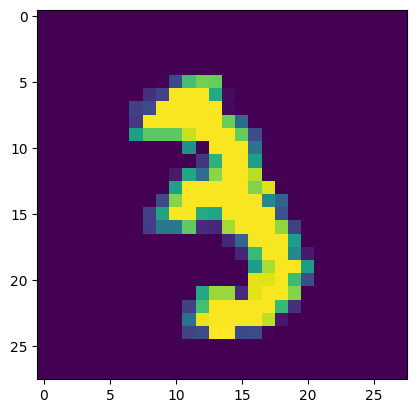

In [9]:
# Mini-batch images and labels.
images, labels = next(iter(train_loader))
print(images.shape,labels.shape)
print('lbl : ',labels[0])
im = images
plt.imshow(tf.ToPILImage(mode='L')(images[0]))
plt.show()

## Iterate over all the batches in the dataset

torch.Size([128, 1, 28, 28]) torch.Size([128])
lbl :  tensor(4)


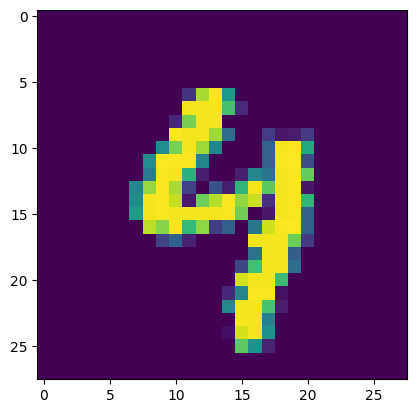

lbl :  tensor(9)


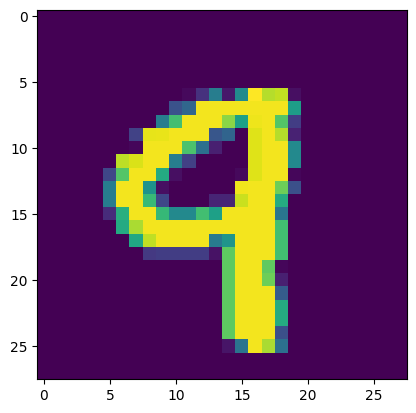

lbl :  tensor(6)


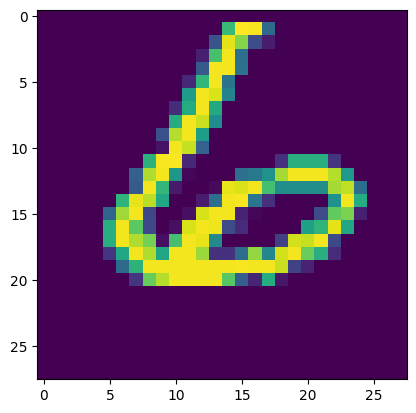

lbl :  tensor(7)


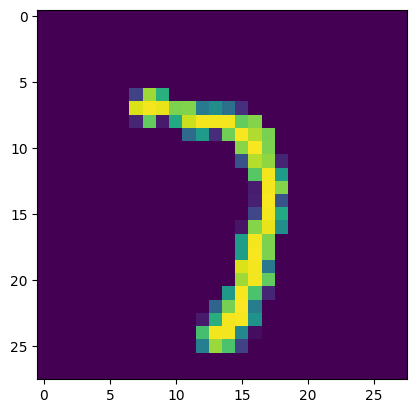

lbl :  tensor(8)


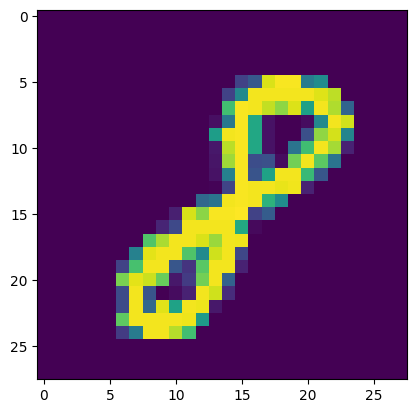

lbl :  tensor(7)


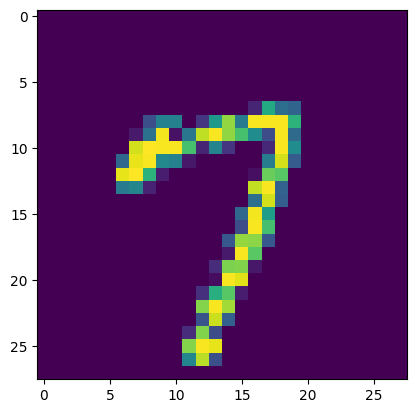

lbl :  tensor(9)


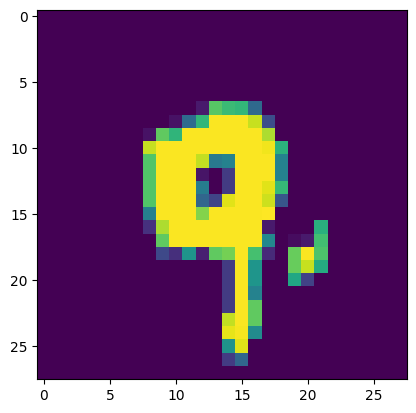

lbl :  tensor(6)


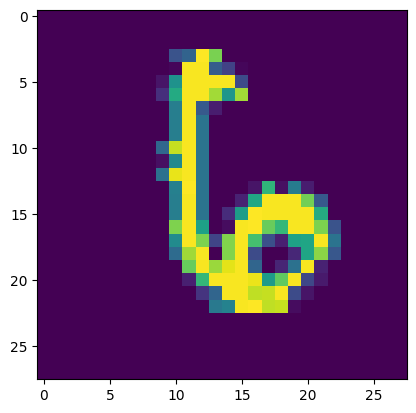

lbl :  tensor(7)


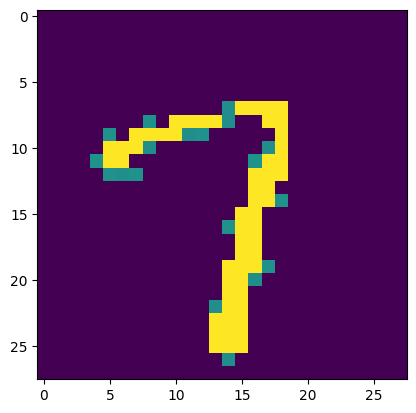

lbl :  tensor(7)


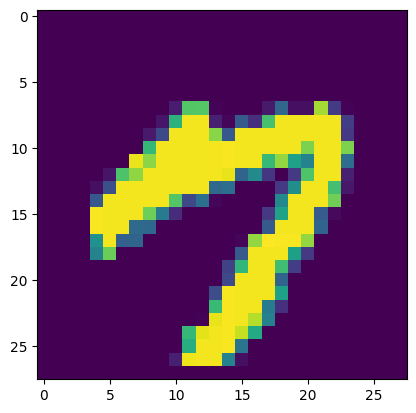

lbl :  tensor(2)


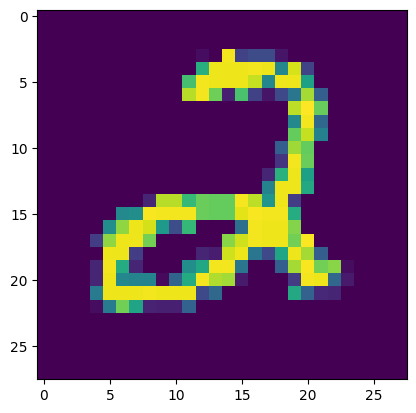

lbl :  tensor(4)


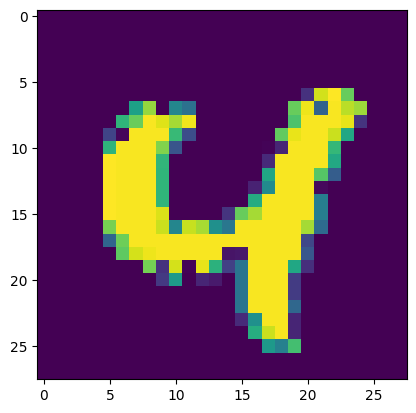

lbl :  tensor(2)


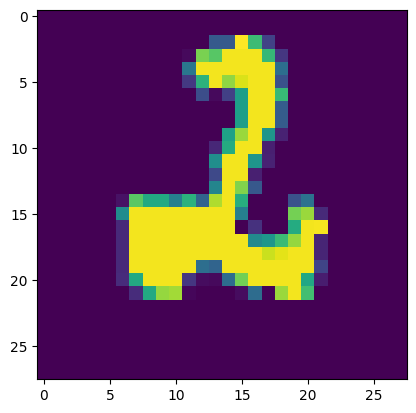

lbl :  tensor(4)


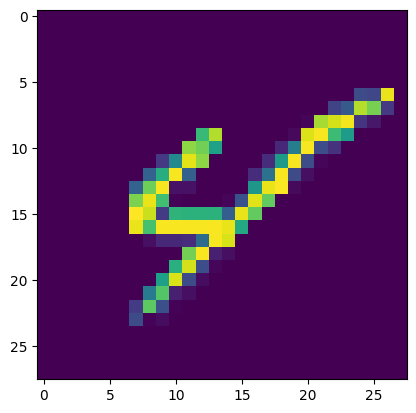

lbl :  tensor(1)


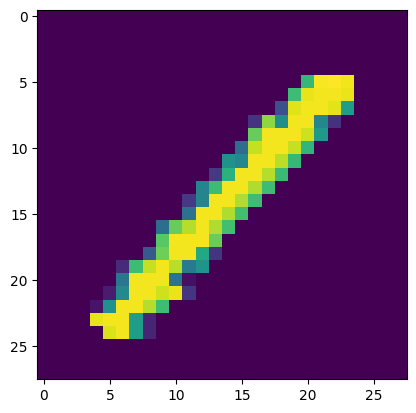

lbl :  tensor(1)


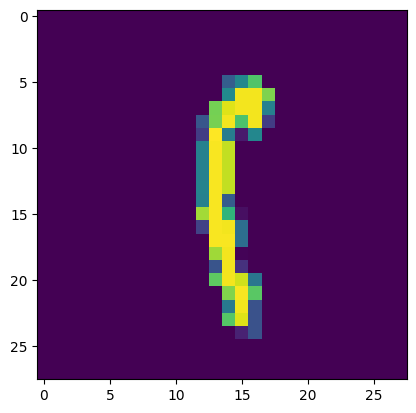

lbl :  tensor(2)


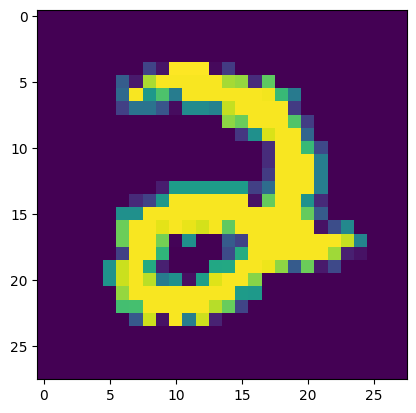

lbl :  tensor(8)


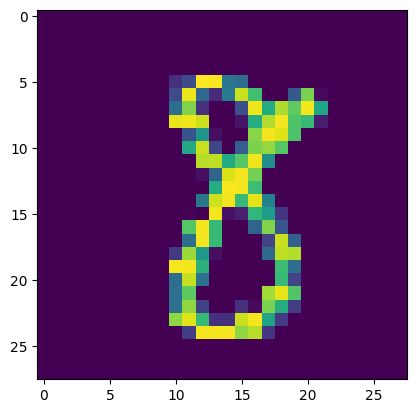

lbl :  tensor(6)


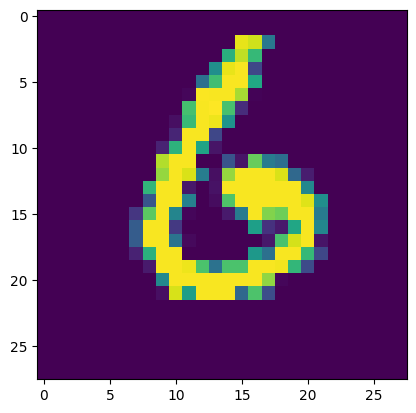

lbl :  tensor(8)


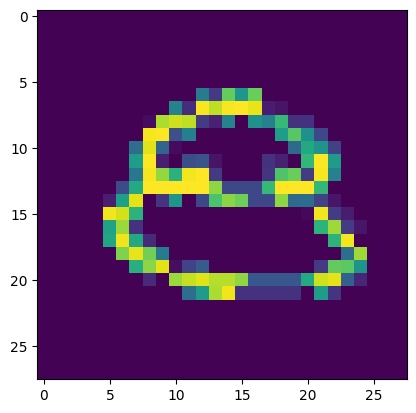

lbl :  tensor(6)


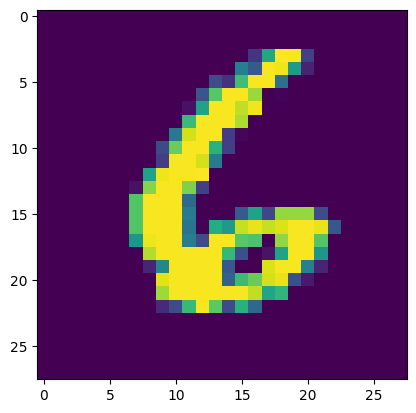

lbl :  tensor(1)


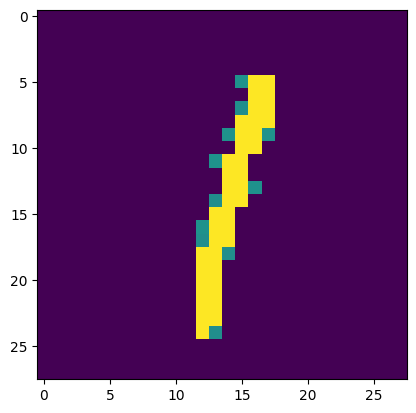

lbl :  tensor(8)


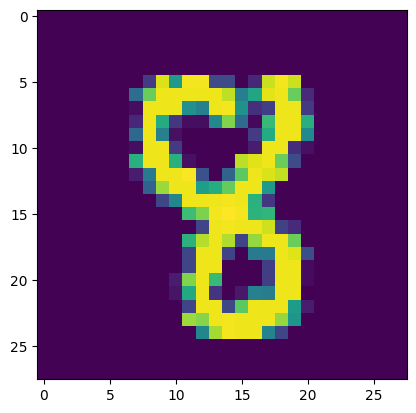

lbl :  tensor(0)


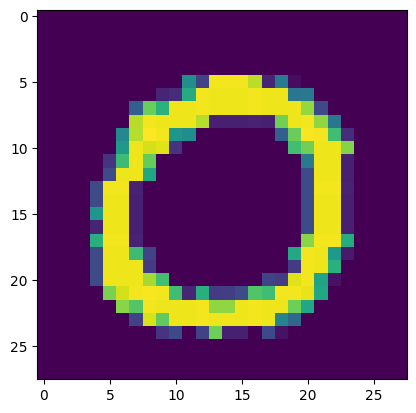

lbl :  tensor(4)


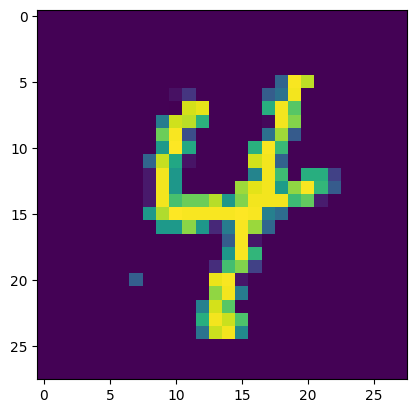

lbl :  tensor(7)


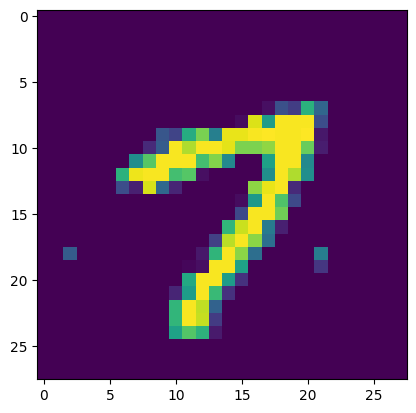

lbl :  tensor(8)


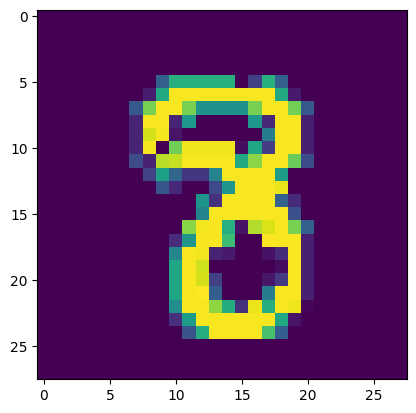

lbl :  tensor(0)


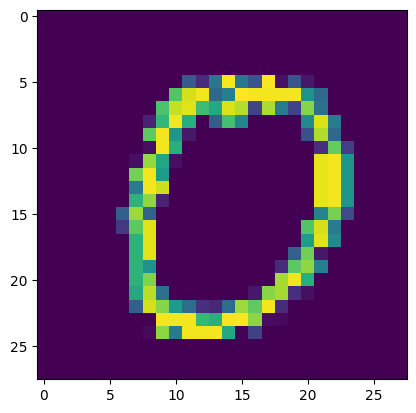

lbl :  tensor(5)


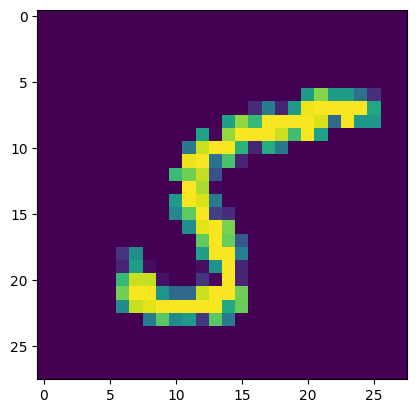

lbl :  tensor(8)


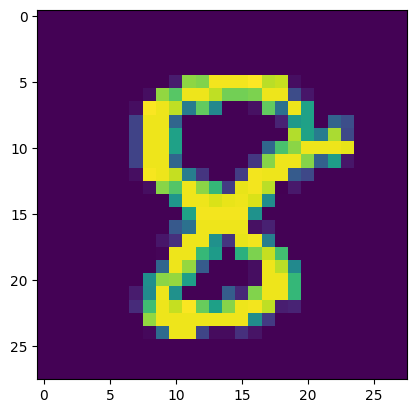

lbl :  tensor(4)


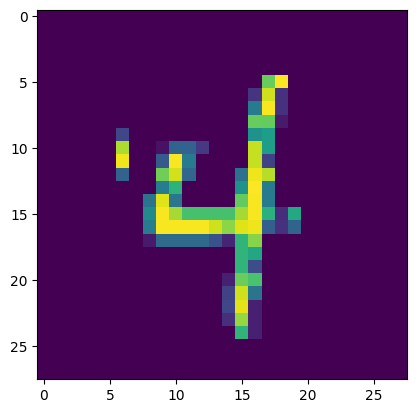

lbl :  tensor(7)


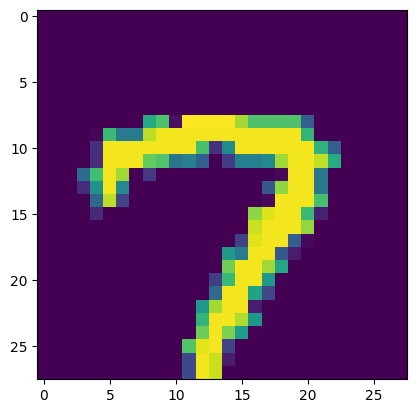

lbl :  tensor(0)


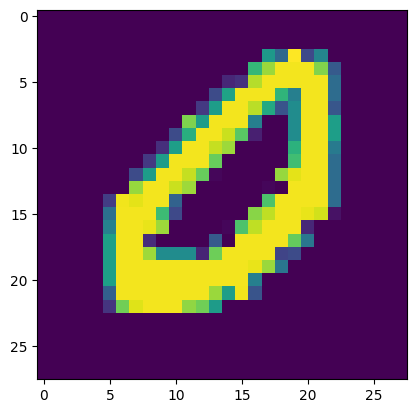

lbl :  tensor(3)


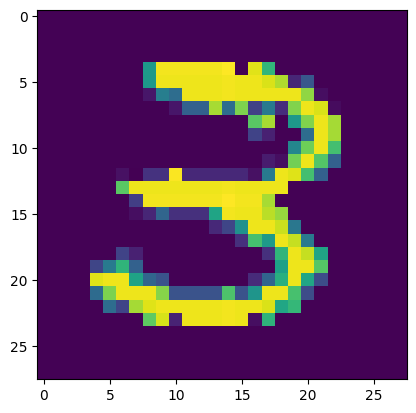

lbl :  tensor(7)


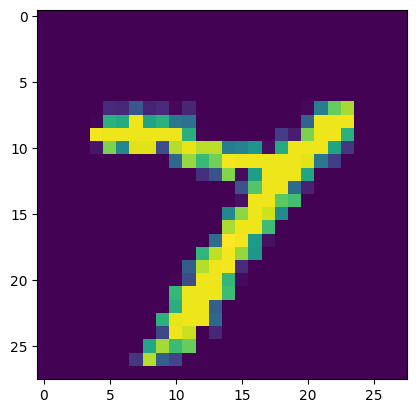

lbl :  tensor(1)


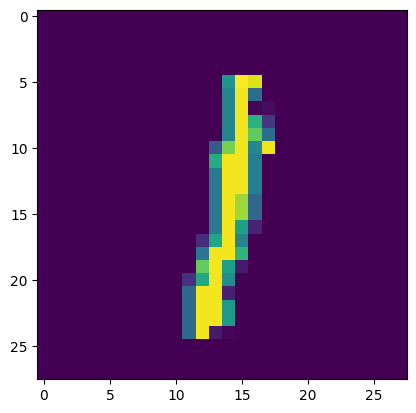

lbl :  tensor(1)


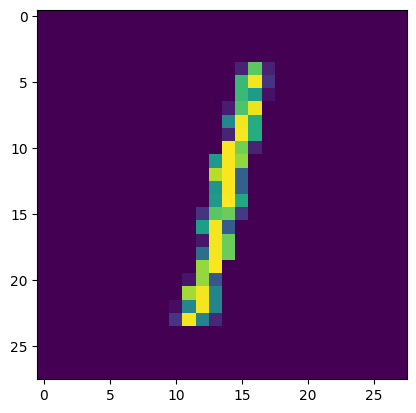

lbl :  tensor(6)


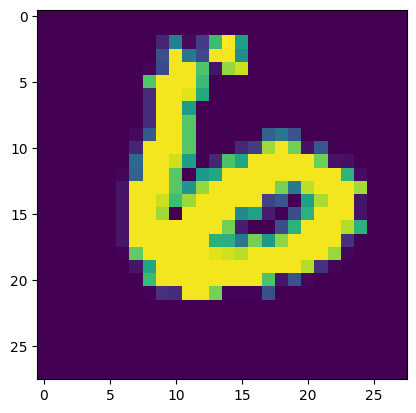

lbl :  tensor(6)


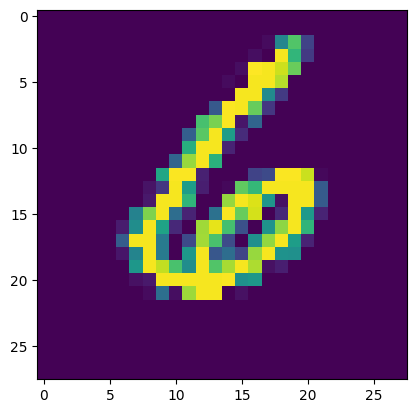

lbl :  tensor(7)


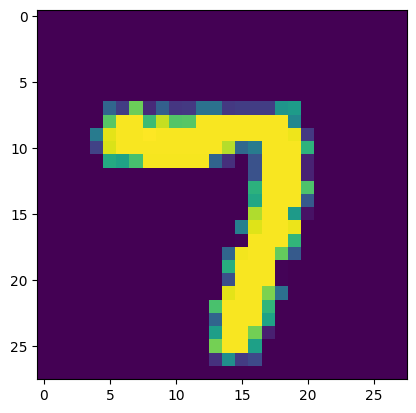

lbl :  tensor(7)


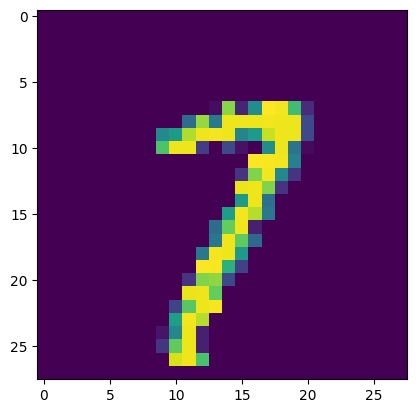

lbl :  tensor(0)


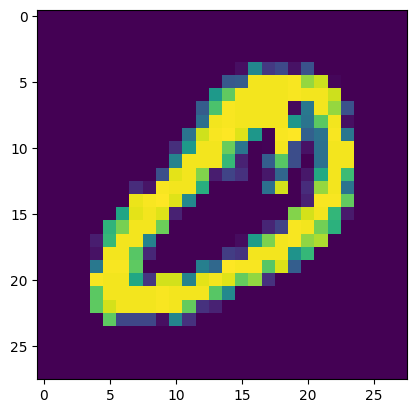

lbl :  tensor(9)


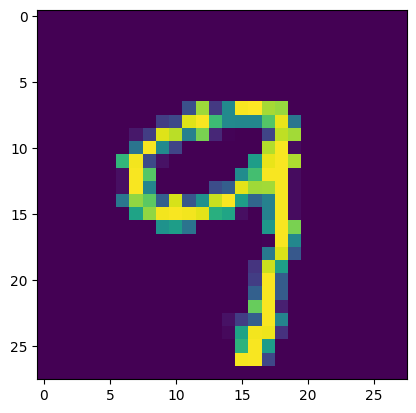

lbl :  tensor(9)


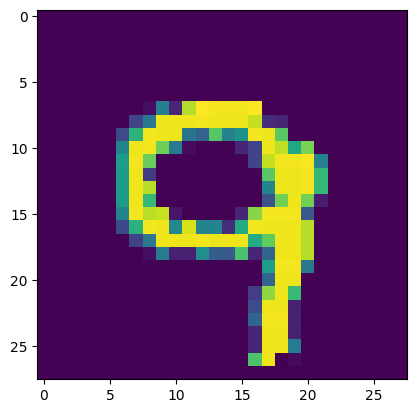

lbl :  tensor(9)


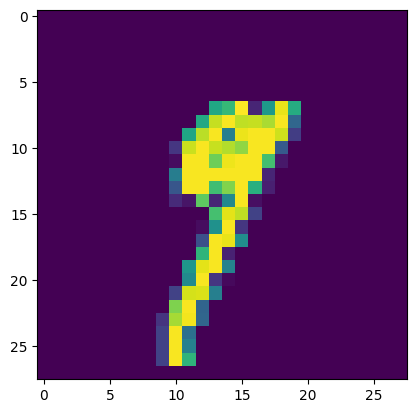

lbl :  tensor(0)


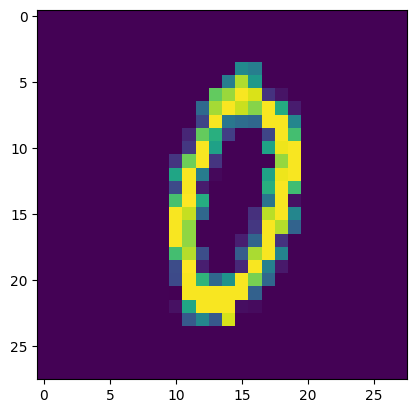

lbl :  tensor(1)


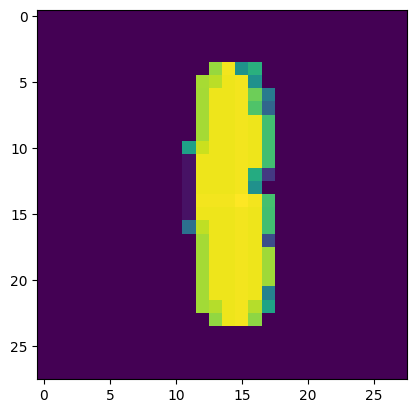

lbl :  tensor(5)


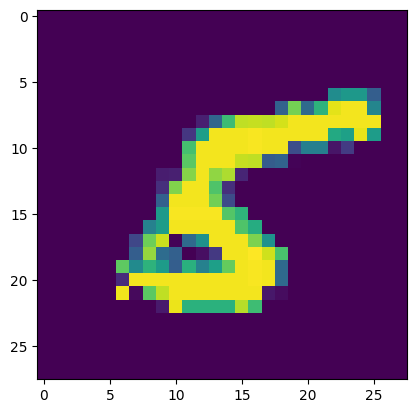

lbl :  tensor(6)


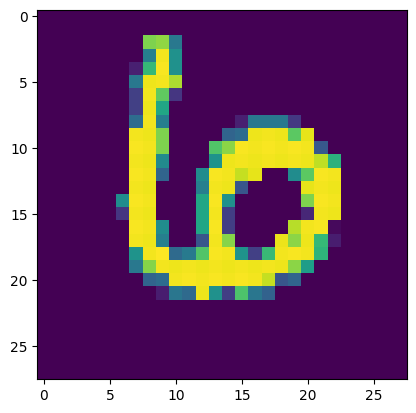

lbl :  tensor(5)


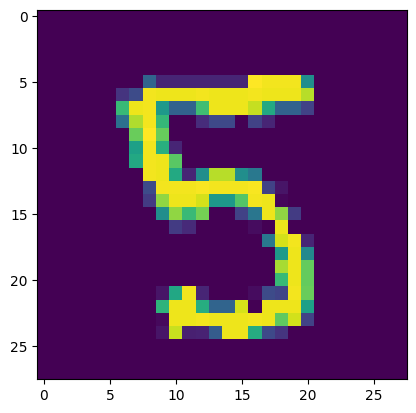

lbl :  tensor(7)


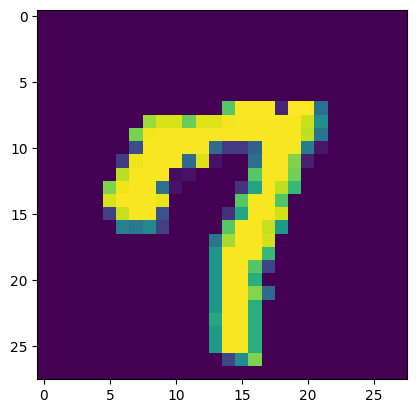

lbl :  tensor(4)


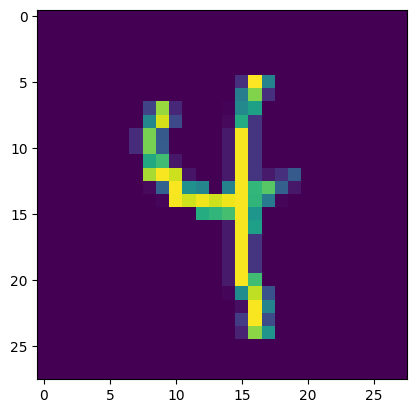

lbl :  tensor(9)


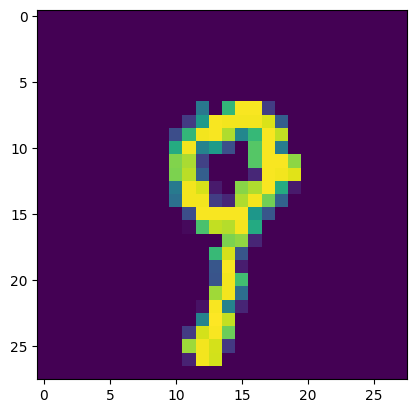

lbl :  tensor(8)


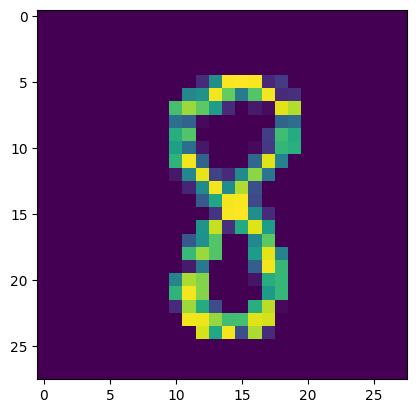

lbl :  tensor(9)


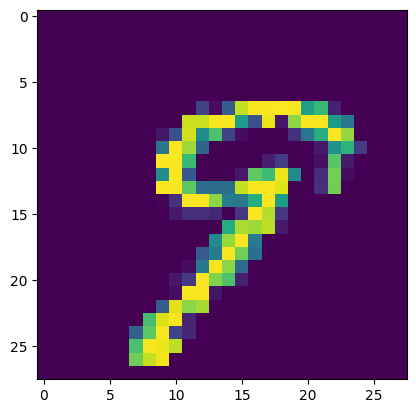

lbl :  tensor(6)


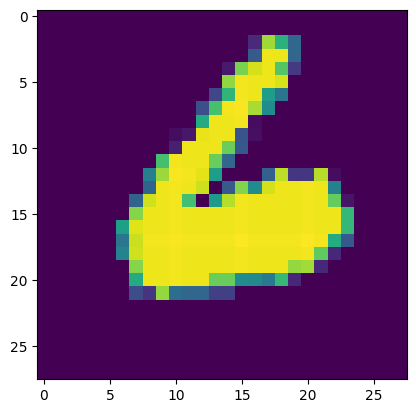

lbl :  tensor(0)


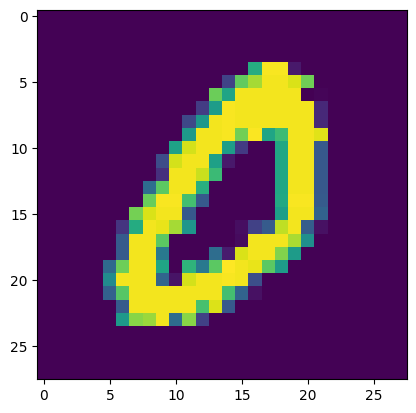

lbl :  tensor(5)


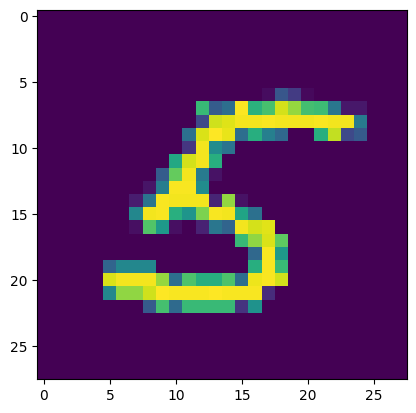

lbl :  tensor(0)


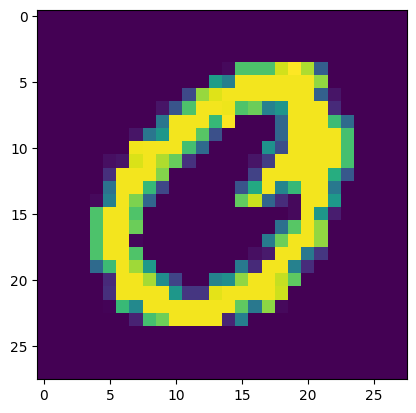

lbl :  tensor(2)


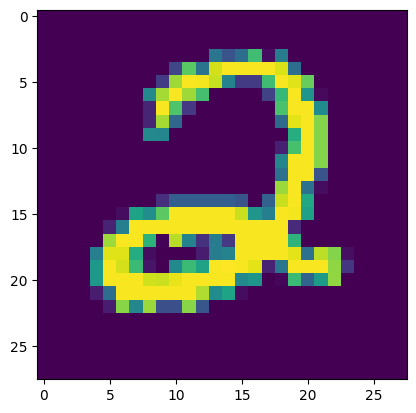

lbl :  tensor(7)


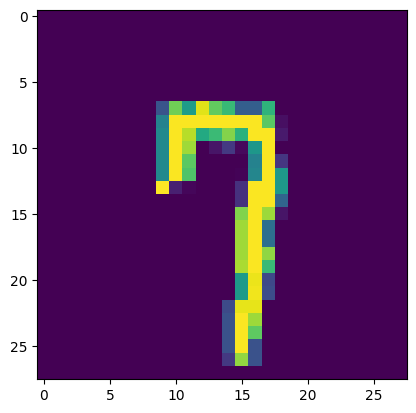

lbl :  tensor(4)


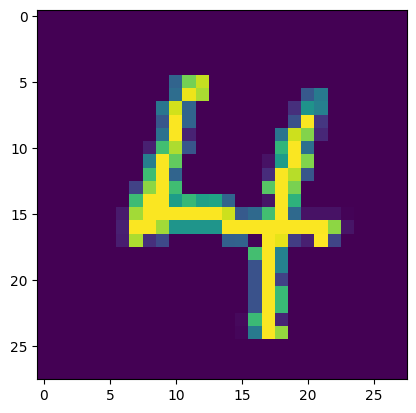

lbl :  tensor(4)


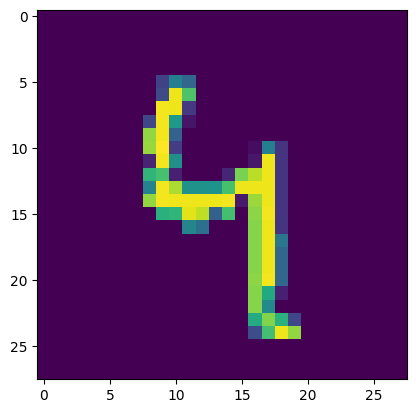

lbl :  tensor(6)


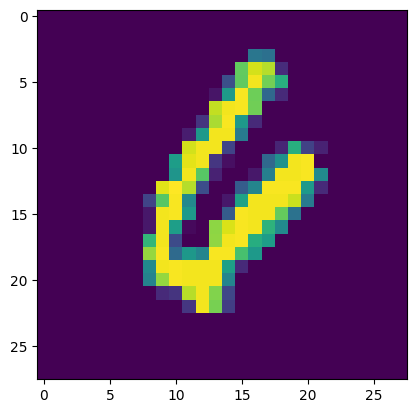

lbl :  tensor(4)


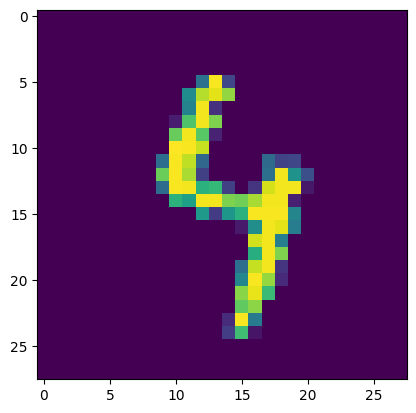

lbl :  tensor(2)


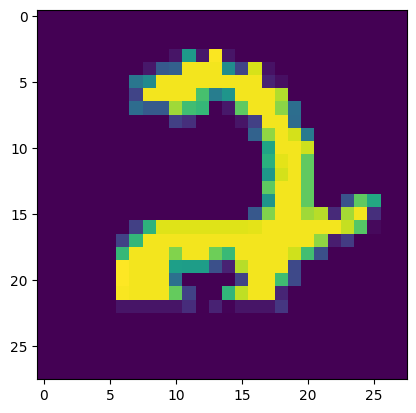

lbl :  tensor(5)


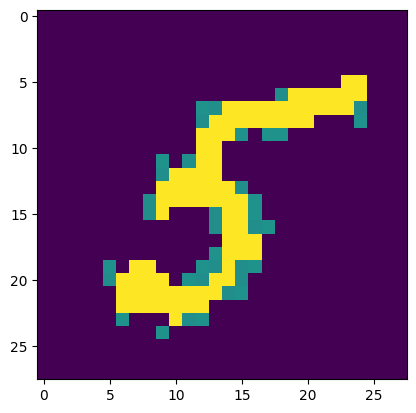

lbl :  tensor(6)


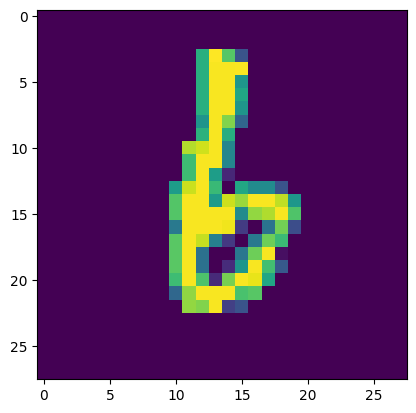

lbl :  tensor(5)


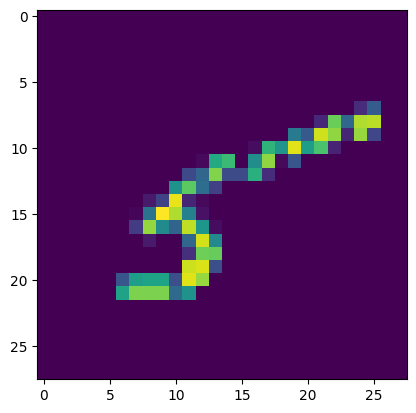

lbl :  tensor(5)


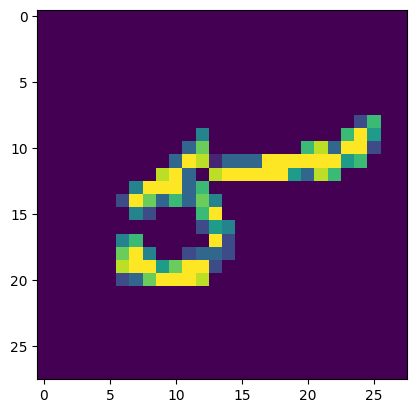

lbl :  tensor(7)


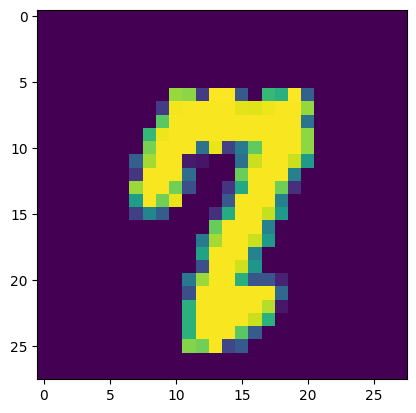

lbl :  tensor(5)


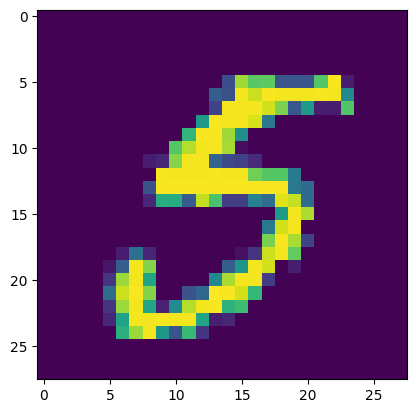

lbl :  tensor(1)


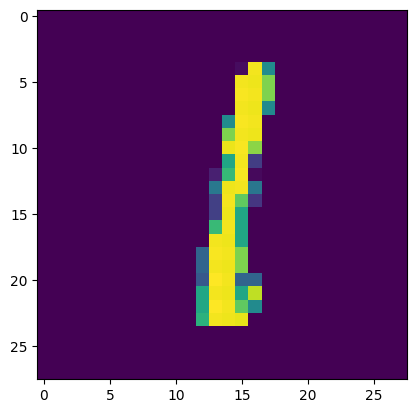

lbl :  tensor(1)


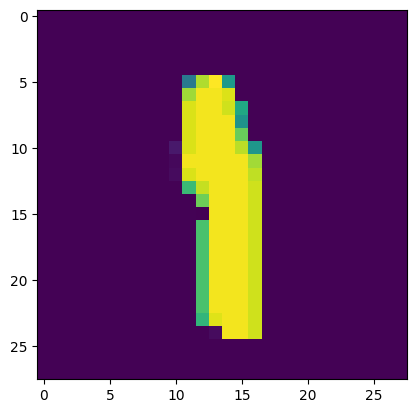

lbl :  tensor(4)


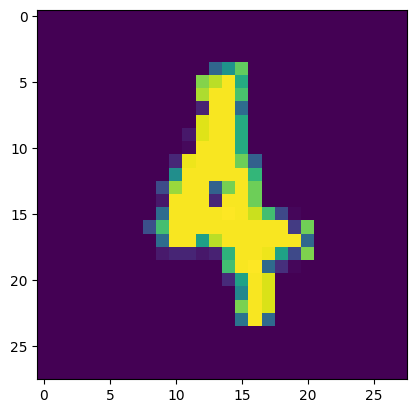

lbl :  tensor(5)


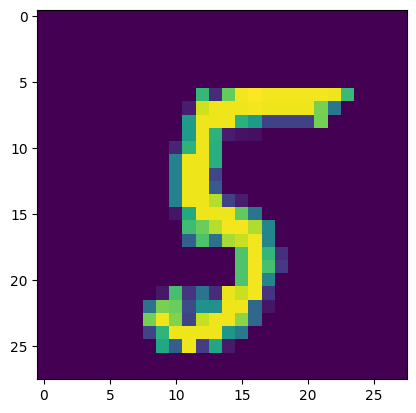

lbl :  tensor(0)


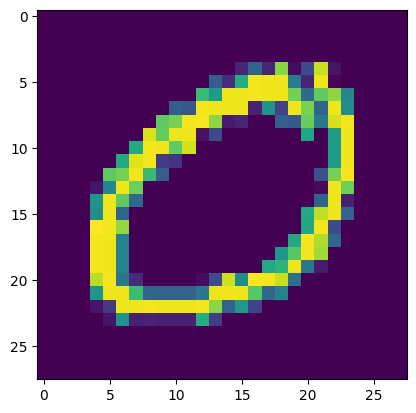

lbl :  tensor(8)


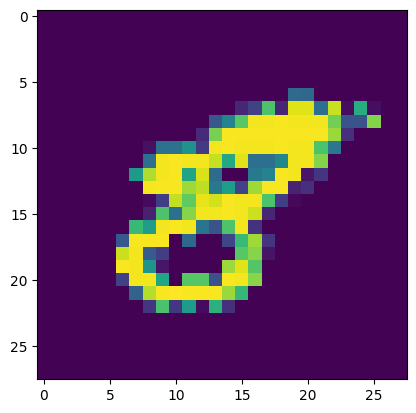

lbl :  tensor(8)


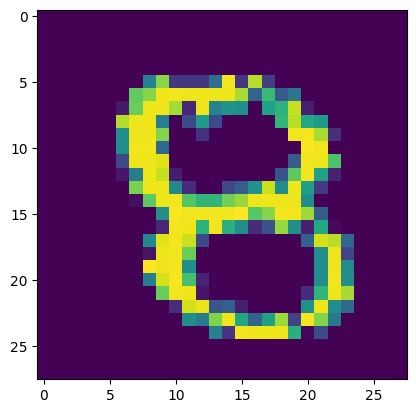

lbl :  tensor(5)


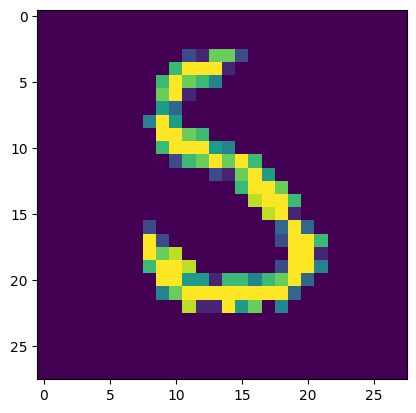

lbl :  tensor(1)


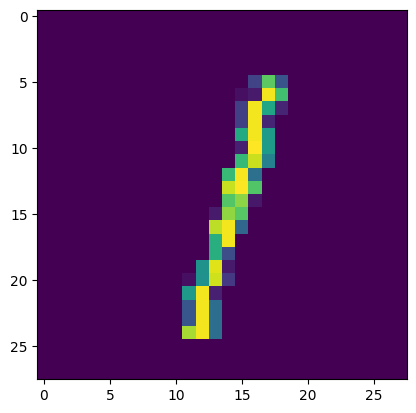

lbl :  tensor(7)


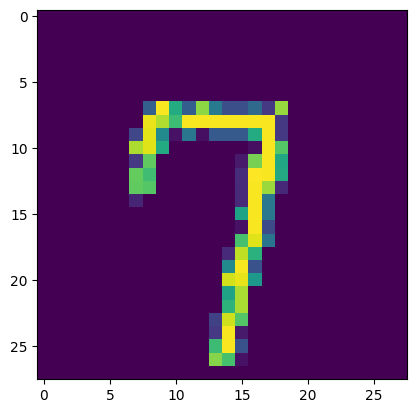

lbl :  tensor(1)


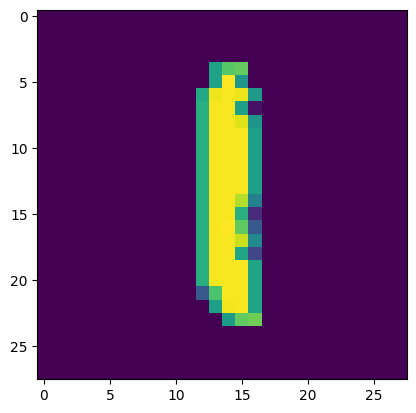

lbl :  tensor(9)


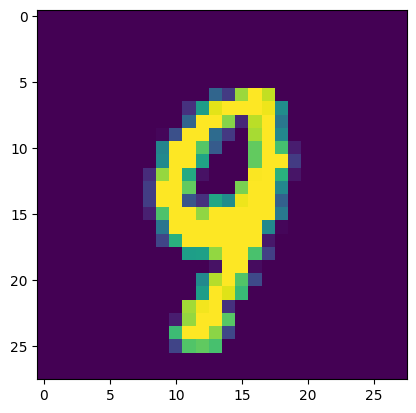

lbl :  tensor(7)


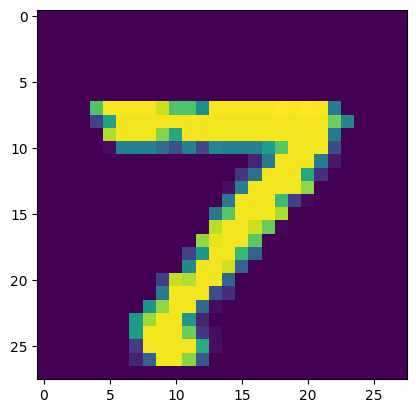

lbl :  tensor(2)


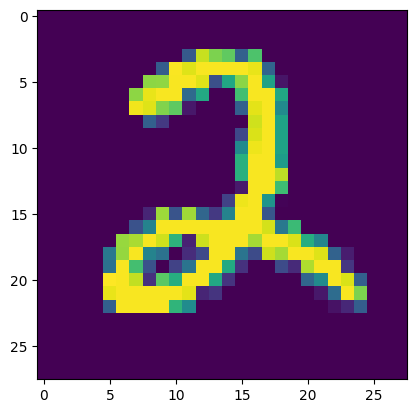

lbl :  tensor(7)


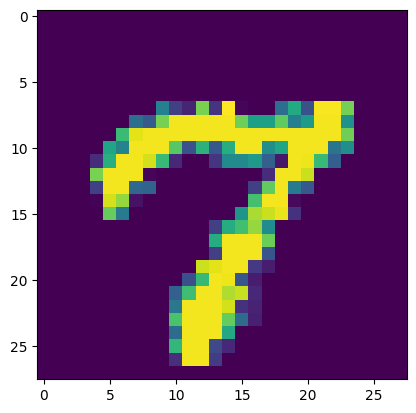

lbl :  tensor(1)


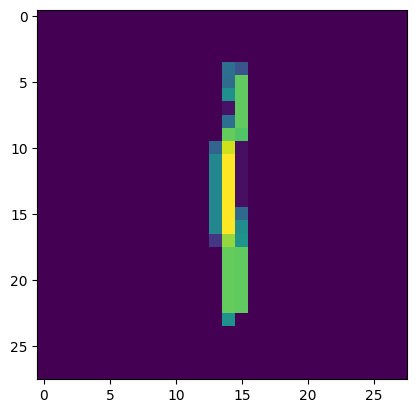

lbl :  tensor(2)


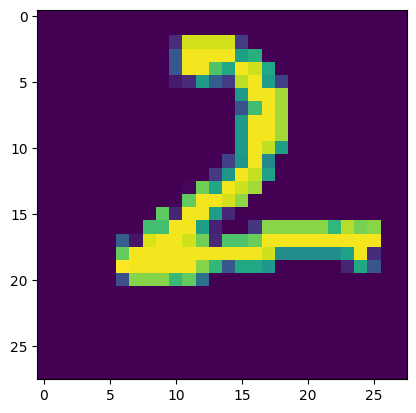

lbl :  tensor(8)


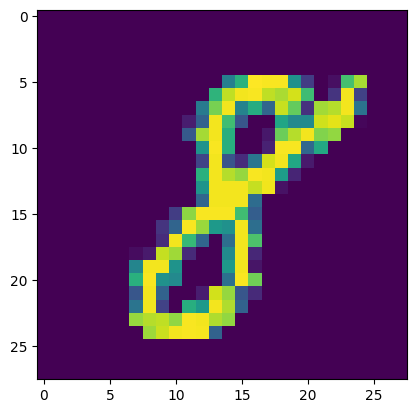

lbl :  tensor(6)


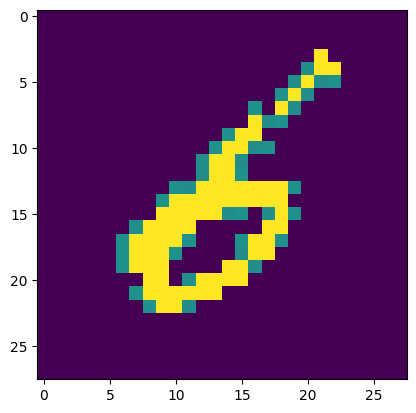

lbl :  tensor(8)


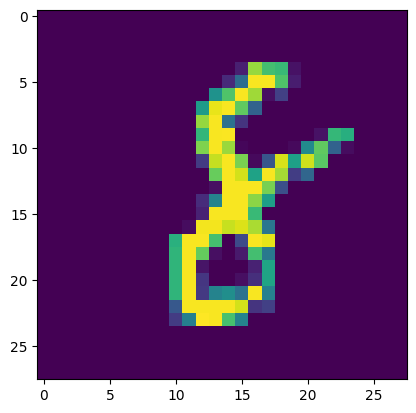

lbl :  tensor(1)


KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [10]:
# Actual usage of the data loader is as below.
for images, labels in train_loader:
  print(images.shape, labels.shape) #images, labels shape
  for img,lbl in zip(images,labels): 
    print('lbl : ',lbl)
    plt.imshow(tf.ToPILImage(mode='L')(img))
    plt.show()
  break

# **Standard pipeline to train Deep Models in PyTorch**

The standard practice on builing the model in pytorch environment is as follows : 


1.  Create Custom Dataset
2.   Create NN model by extending torch.nn class
3.   Creating the loss function and optimizer
4.   Actual training (including validation loss optional) and saving a model in parallel
5.   Analysing the output

## 1 Creating Custom dataset

In [11]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2022/P3/Data/'

#Making native class loader
class MNIST(torch.utils.data.Dataset):
    
    def __init__(self,dataDir = data_path+'/mnist/train.pt',transform = None):
        self.data, self.labels = torch.load(dataDir)
        self.transform = transform
        
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data.numpy(), mode='L')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
        if self.transform is not None : 
            data = self.transform(data)
        
        return data,lbl
    
        pass
    def __len__(self):
        return len(self.data)
 


tr = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean = [.5], std = [.5])
        ])

 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Define the model (CNN)

Making Standard Pytorch Network Class. In this case is two layers cnn ended with bottleneck FC. 

In [12]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3
        
        self.fc = nn.Linear(7*7*32, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [13]:
CNN = ConvNet()
CNN = CNN.cuda()

## 3. Creating loss function, optimizers and hyperparameters

In [14]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5


## 4. Actual Training

In [15]:
# Train the model
if True :
    MNISTTrain = MNIST(data_path+'/mnist/train.pt',tr)
    train_loader = torch.utils.data.DataLoader(dataset=MNISTTrain,
                                                batch_size=256, 
                                                shuffle=True)
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Save the model checkpoint
    torch.save(CNN.state_dict(), results_path+'/model.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))


Epoch [1/5], Step [100/235], Loss: 0.2267
Epoch [1/5], Step [200/235], Loss: 0.1188
Epoch [2/5], Step [100/235], Loss: 0.0708
Epoch [2/5], Step [200/235], Loss: 0.0712
Epoch [3/5], Step [100/235], Loss: 0.0573
Epoch [3/5], Step [200/235], Loss: 0.0286
Epoch [4/5], Step [100/235], Loss: 0.0656
Epoch [4/5], Step [200/235], Loss: 0.0422
Epoch [5/5], Step [100/235], Loss: 0.0628
Epoch [5/5], Step [200/235], Loss: 0.0199


##5. Analysing the output including testing

In [16]:
#Load the model
CNN.load_state_dict(torch.load(results_path+'/model.ckpt'))

# Test the model
if True : 
    # Load test dataset
    MNISTTest = MNIST(data_path+'/mnist/test.pt',tr)
    test_loader = torch.utils.data.DataLoader(dataset=MNISTTest,
                                               batch_size=64, 
                                               shuffle=True)
    CNN.eval() # Set the model in evaluation mode
    
    # Compute testing accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.49 %


Predicted Label: 2


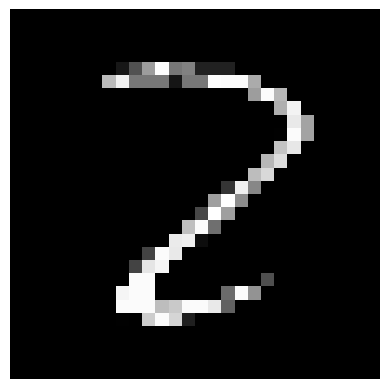

Predicted Label: 9


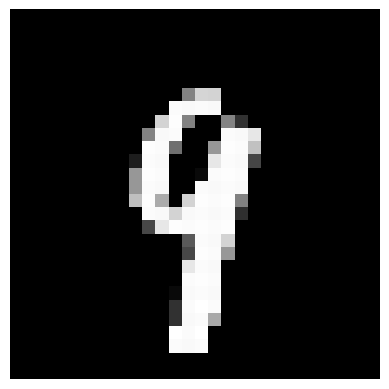

Predicted Label: 7


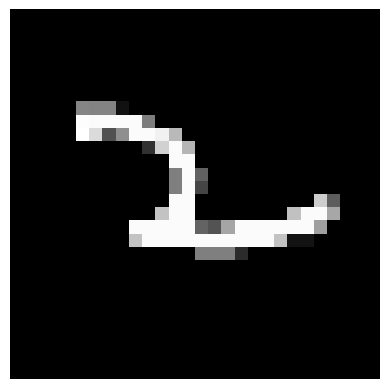

Predicted Label: 9


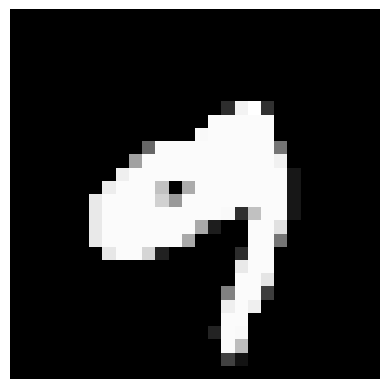

Predicted Label: 8


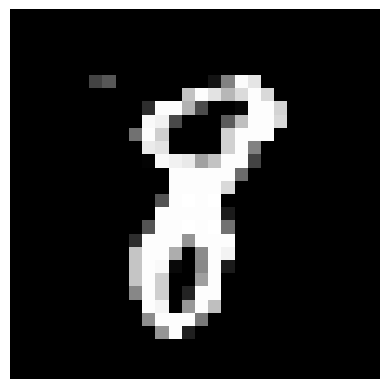

Predicted Label: 7


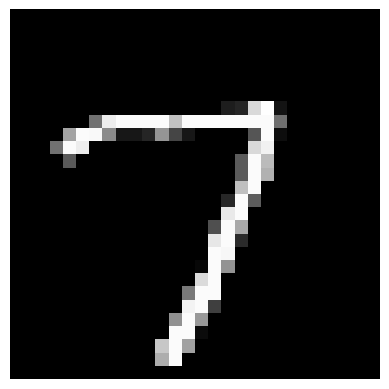

Predicted Label: 2


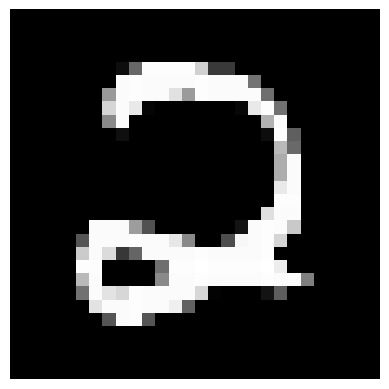

Predicted Label: 5


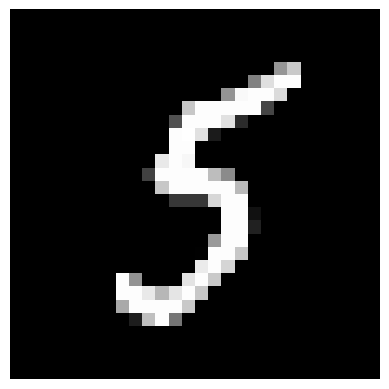

Predicted Label: 9


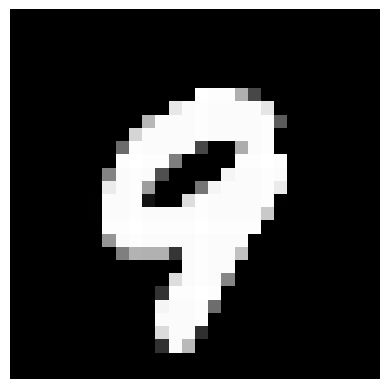

Predicted Label: 7


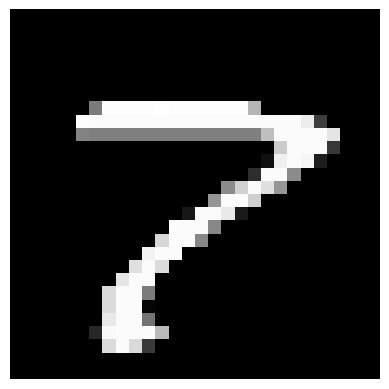

Predicted Label: 9


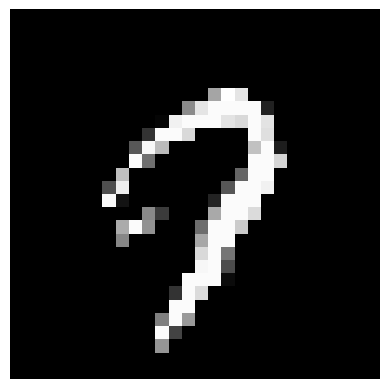

Predicted Label: 5


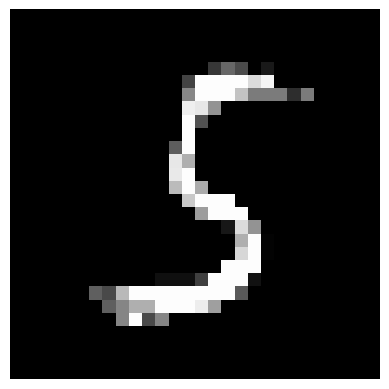

Predicted Label: 1


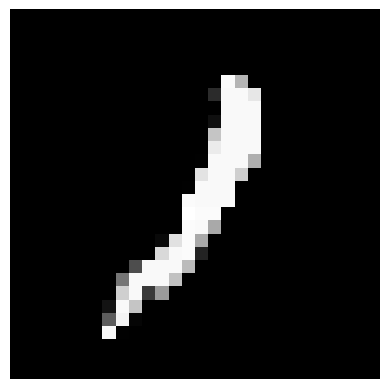

Predicted Label: 4


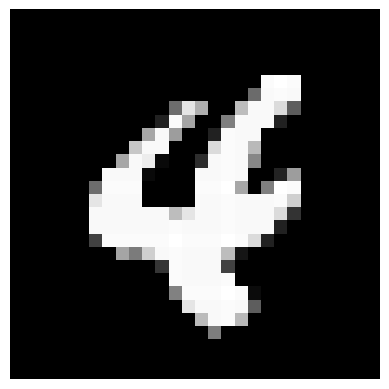

Predicted Label: 0


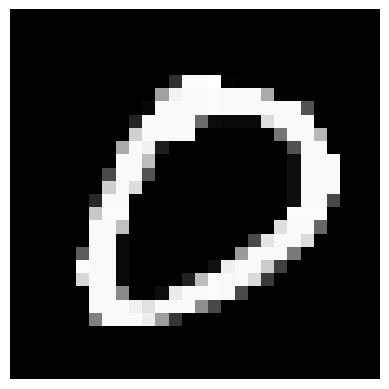

Predicted Label: 9


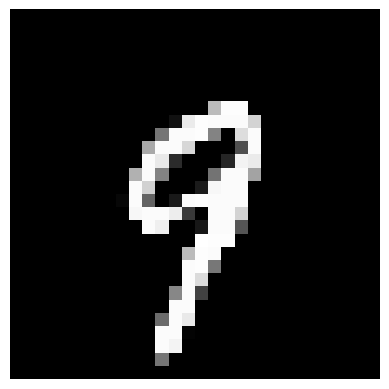

In [17]:
import numpy as np
for im, predicted_label in zip(images,predicted):
  im = im.cpu().numpy().squeeze()
  print('Predicted Label: ' + str(predicted_label.item()))
  plt.imshow(im[:,:,np.newaxis].repeat(3,axis=2))
  plt.axis('off')
  plt.show()

